# AI-LAB SESSION 3: Markov Decision Process

In the third session we will work on the Markov decision process (MDP)

## Lava environments

The environments used are **LavaFloor** (visible in the figure) and its variations.
![LavaFloor](images/lava.png)
The agent starts in cell $(0, 0)$ and has to reach the treasure in $(2, 3)$. In addition to the walls of the previous environments, the floor is covered with lava, there is a black pit of death. What a nice place to visit!

Moreover, the agent can't comfortably perform its actions that instead have a stochastic outcome (visible in the figure)
![DynAct](images/dynact.png)
The action dynamics is the following:
- $P(0.8)$ of moving in the desired direction
- $P(0.1)$ of moving in a direction 90° with respect to the desired direction

Finally, since the floor is covered in lava, the agent receives a negative reward for each of its steps!
- <span style="color:orange">-0.04</span> for each lava cell (L)
- <span style="color:red">-5</span> for the black pit (P). End of episode
- <span style="color:green">+1</span> for the treasure (G). End of episode

## Assignment 1

Your first assignment is to implement the *Value Iteration* algorithm on **LavaFloor**. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state. After the correctness of your implementations have been assessed, you can run the algorithms on other four lava environments: **VeryBadLavaFloor**, **NiceLavaFloor**, **BiggerLavaFloor**, **HugeLavaFloor**

### Hint

The first version of your implementation should use for loops and such as in the pseudocode. Once the result is satisfying try to use as many numpy operations as possible to speed up the code

In [11]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
import envs
import numpy as np
from utils.funcs import run_episode, plot
from timeit import default_timer as timer
from tqdm import tqdm_notebook as tqdm

The following function has to be implemented

In [96]:
def value_iteration(env, maxiters, gamma, delta):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        env: OpenAI Gym environment
        maxiters: max iterations allowed
        gamma: gamma value
        delta: delta value
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    
    ### ORIGINALE SECONDO L'ALGORITMO - versione con i cicli for
    """
    v = np.zeros(env.observation_space.n, dtype="double")  # Initial policy
    i = 0
    while True:
        v1 = v.copy()
        i += 1
        for s in range(env.observation_space.n): #itero sugli stati (for each s in S:)
            sum_list = []
            for a in range(env.action_space.n): #(for each a in As:)
                sum_ = 0
                for s1 in range(env.observation_space.n): #(for each s' in S:)
                    sum_ += env.T[s, a, s1]*(env.R[s, a, s1] + gamma*v[s1]) #T(s, a, s')(R(s, a, s') + γV(s'))
                sum_list.append(sum_)
            v[s] = np.max(sum_list)
            #print(v)
        #print("ITER: " + str(i))
        if np.max(np.abs(v - v1)) < delta or i == maxiters:
            break
    
    pi = np.zeros(env.observation_space.n, dtype="int8")
    for s in range(env.observation_space.n): #itero sugli stati (for each s in S:)
        sum_list = []
        for a in range(env.action_space.n): #(for each a in As:)
            sum_ = 0
            for s1 in range(env.observation_space.n): #(for each s' in S:)
                sum_ += env.T[s, a, s1]*(env.R[s, a, s1] + gamma*v[s1]) #T(s, a, s')(R(s, a, s') + γV(s'))
            sum_list.append(sum_)
        pi[s] = np.argmax(sum_list)
        
    return np.asarray(pi)
    """
    
    ### VERSIONE GIT - MATRICI - sistemata con tutor

    v = np.zeros(env.observation_space.n, dtype="int8")
    viter = 0
    tr = env.T * env.R
    while True:
        v1 = np.copy(v)
        viter += 1
        #for s in range(env.observation_space.n): #NB<----------------------------- removed
        v = np.max(np.sum(tr,axis=2) + np.sum(env.T*gamma*v,axis=2),axis=1)
        if np.max(np.abs(v - v1)) < delta or viter == maxiters:
            break

    #p = np.zeros(env.observation_space.n, dtype="int8")
    p = np.argmax(np.sum(tr,axis=2) + np.sum(env.T*gamma*v,axis=2),axis=1) 
    
    return np.asarray(p)


The following code executes and *Value Iteration* and prints the resulting policy

In [97]:
# Learning parameters
delta = 1e-3
gamma = .9
maxiters = 50  # Max number of iterations to perform

envname_list = ["LavaFloor-v0", "VeryBadLavaFloor-v0", "NiceLavaFloor-v0"]
solutions_list = {"LavaFloor-v0":[['D','L','L','U'],['D','L','L','L'],['R','R','R','L']],\
                "VeryBadLavaFloor-v0":[['R','R','R','D'],['D','L','R','L'],['R','R','R','L']],\
                "NiceLavaFloor-v0":[['L','L','L','U'],['L','L','L','L'],['L','L','L','L']]}

for envname in envname_list:
    print("\n----------------------------------------------------------------")
    print("\tEnvironment: ", envname)
    print("----------------------------------------------------------------\n")

    env = gym.make(envname)
    env.render()

    t = timer()
    policy = value_iteration(env, maxiters, gamma, delta)

    print("\n\nValue Iteration:\n----------------------------------------------------------------"
          "\nExecution time: {0}s\nPolicy:\n{1}".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
                                                                                            env.rows, env.cols))))
    if envname in solutions_list:
        res = str(np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols))).replace('\n ',',').replace(' ',',')
        sol = str(solutions_list[envname]).replace(' ','')
        if res == sol:
            print("--------------------------> OK: ✔")
        else:
            print("--------------------------> NO: ✕")


----------------------------------------------------------------
	Environment:  LavaFloor-v0
----------------------------------------------------------------

[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]


Value Iteration:
----------------------------------------------------------------
Execution time: 0.0026s
Policy:
[['D' 'L' 'L' 'U']
 ['D' 'L' 'L' 'L']
 ['R' 'R' 'R' 'L']]
--------------------------> OK: ✔

----------------------------------------------------------------
	Environment:  VeryBadLavaFloor-v0
----------------------------------------------------------------

[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]


Value Iteration:
----------------------------------------------------------------
Execution time: 0.0007s
Policy:
[['R' 'R' 'R' 'D']
 ['D' 'L' 'R' 'L']
 ['R' 'R' 'R' 'L']]
--------------------------> OK: ✔

----------------------------------------------------------------
	Environment:  NiceLavaFloor-v0
-------------------------------------------

Correct results for *Value Iteration* can be found [here](results/value_iteration_results.txt)

## Assignment 2

Your first assignment is to implement the *Policy Iteration* algorithm on **LavaFloor**. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state. After the correctness of your implementations have been assessed, you can run the algorithms on other four lava environments: **VeryBadLavaFloor**, **NiceLavaFloor**, **BiggerLavaFloor**, **HugeLavaFloor**

### Hint

The first version of your implementation should use for loops and such as in the pseudocode. Once the result is satisfying try to use as many numpy operations as possible to speed up the code.

The following function has to be implemented

In [98]:
def policy_iteration(environment, pmaxiters, vmaxiters, gamma, delta):
    """
    Performs the policy iteration algorithm for a specific environment
    
    Args:
        environment: environment
        pmaxiters: max iterations allowed for the policy improvement
        vmaxiters: max iterations allowed for the policy evaluation
        gamma: gamma value
        delta: delta value
    
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    
    ## ORIGINALE SECONDO L'ALGORITMO - versione con i cicli for
    """
    v = np.zeros(env.observation_space.n, dtype="double")  # Initial policy
    p = np.zeros(env.observation_space.n, dtype="int8")
    piter = 0
    while True:
        p1 = np.copy(p)
        piter += 1
        viter = 0
        # ---- Evaluate Policy
        while True:
            v1 = v.copy()
            viter += 1
            for s in range(env.observation_space.n): #itero sugli stati (for each s in S:)
                sum_ = 0
                for s1 in range(env.observation_space.n): #(for each s' in S:)
                    sum_ += env.T[s, p[s], s1]*(env.R[s, p[s], s1] + gamma*v[s1]) #T(s, pi_s, s')(R(s, pi_s, s') + γV(s'))
                v[s] = sum_
            if np.max(np.abs(v - v1)) < delta or viter == vmaxiters:
                break
        # ---- Improve Policy
        for s in range(env.observation_space.n): #itero sugli stati (for each s in S:)
            sum_list = []
            for a in range(env.action_space.n): #(for each a in As:)
                sum_ = 0
                for s1 in range(env.observation_space.n): #(for each s' in S:)
                    sum_ += env.T[s, a, s1]*(env.R[s, a, s1] + gamma*v[s1]) #T(s, a, s')(R(s, a, s') + γV(s'))
                sum_list.append(sum_)
            p[s] = np.argmax(sum_list)
        if np.array_equal(p,p1) or piter == pmaxiters:
            break
    
    return np.asarray(p)
    """

    ### VERSIONE MATRICI - sistemata con tutor
    
    v = np.zeros(env.observation_space.n, dtype="int8")
    p = np.zeros(env.observation_space.n, dtype="int8")
    piter = 0
    while True:
        p1 = np.copy(p)
        piter += 1
        viter = 0
        tr = env.T * env.R
        while True:
            v1 = np.copy(v)
            viter += 1
            #for s in range(env.observation_space.n):
            v = (np.sum(tr,axis=2) + np.sum(env.T*gamma*v,axis=2))[np.arange(env.observation_space.n),p]
            if np.max(np.abs(v - v1)) < delta or viter == vmaxiters:
                break
        p = np.argmax(np.sum(tr,axis=2) + np.sum(env.T*gamma*v,axis=2),axis=1)
        if np.array_equal(p, p1) or piter == pmaxiters:
            break
    
    return np.asarray(p)


The following code executes and *Value Iteration* and prints the resulting policy

In [99]:
# Learning parameters
delta = 1e-3
gamma = .9
pmaxiters = 50  # Max number of policy improvements to perform
vmaxiters = 5  # Max number of iterations to perform while evaluating a policy

envname_list = ["LavaFloor-v0", "VeryBadLavaFloor-v0", "NiceLavaFloor-v0"]
solutions_list = {"LavaFloor-v0":[['D','L','L','U'],['D','L','L','L'],['R','R','R','L']],\
                "VeryBadLavaFloor-v0":[['R','R','R','D'],['D','L','R','L'],['R','R','R','L']],\
                "NiceLavaFloor-v0":[['L','U','L','U'],['L','L','L','L'],['L','U','L','L']]}

for envname in envname_list:
    print("\n----------------------------------------------------------------")
    print("\tEnvironment: ", envname)
    print("----------------------------------------------------------------\n")

    env = gym.make(envname)
    env.render()

    t = timer()
    policy = policy_iteration(env, pmaxiters, vmaxiters, gamma, delta)

    print("\n\nPolicy Iteration:\n----------------------------------------------------------------"
          "\nExecution time: {0}s\nPolicy:\n{1}".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
                                                                                            env.rows, env.cols))))
    if envname in solutions_list:
        res = str(np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols))).replace('\n ',',').replace(' ',',')
        sol = str(solutions_list[envname]).replace(' ','')
        if res == sol:
            print("--------------------------> OK: ✔")
        else:
            print("--------------------------> NO: ✕  ⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠⚠")


----------------------------------------------------------------
	Environment:  LavaFloor-v0
----------------------------------------------------------------

[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]


Policy Iteration:
----------------------------------------------------------------
Execution time: 0.0025s
Policy:
[['D' 'L' 'L' 'U']
 ['D' 'L' 'L' 'L']
 ['R' 'R' 'R' 'L']]
--------------------------> OK: ✔

----------------------------------------------------------------
	Environment:  VeryBadLavaFloor-v0
----------------------------------------------------------------

[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]


Policy Iteration:
----------------------------------------------------------------
Execution time: 0.002s
Policy:
[['R' 'R' 'R' 'D']
 ['D' 'L' 'R' 'L']
 ['R' 'R' 'R' 'L']]
--------------------------> OK: ✔

----------------------------------------------------------------
	Environment:  NiceLavaFloor-v0
------------------------------------------

Correct results for *Policy Iteration* can be found [here](results/policy_iteration_results.txt)

## Comparison

The following code performs a comparison between *Value Iteration* and *Policy Iteration* by plotting the accumulated rewards of each episode with iterations in range $[1, 50]$. Try it on all the previous environments and also on **HugeLavaFloor** (might take a long time if not optimizied via numpy)


----------------------------------------------------------------
	Environment:  HugeLavaFloor-v0
----------------------------------------------------------------

[['S' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'P' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'W' 'L' 'L' 'W' 'L' 'L' 'L']
 ['L' 'L' 'P' 'W' 'L' 'L' 'W' 'L' 'P' 'L']
 ['L' 'L' 'L' 'W' 'L' 'L' 'W' 'L' 'L' 'L']
 ['L' 'L' 'L' 'W' 'W' 'W' 'W' 'L' 'L' 'L']
 ['L' 'L' 'P' 'L' 'L' 'L' 'L' 'L' 'L' 'P']
 ['L' 'L' 'L' 'L' 'L' 'P' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['P' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'G']]





Execution time: 1.9218s
Leaning rate comparison:
VI: [-4.    -4.    -4.    -4.    -4.    -4.    -4.    -4.    -4.    -4.    -4.    -4.    -4.    -4.     5.864  7.128  8.456  7.064  9.096  9.068  9.024  9.092  9.16   9.004  9.104  9.132  9.008  8.988  9.072  9.116  9.016  9.112  9.056  9.072  9.184  9.     9.064  9.004  9.14   9.092  9.108  9.136  8.972  8.988  9.04   9.056  8.98   9.072  9.068  9.068  9.048]
PI: [-4.    -4.    -4.    -4.    -4.    -4.     8.868  9.068  9.     9.1    9.06   9.024  9.1    9.028  9.08   9.036  9.064  9.064  9.108  9.02   9.136  9.092  9.012  9.052  9.152  9.076  9.02   9.1    9.02   9.028  9.056  9.036  9.096  9.128  8.976  9.076  9.164  9.036  9.148  9.084  8.968  9.092  8.876  9.092  9.088  9.052  9.104  9.092  9.02   9.072  9.076]


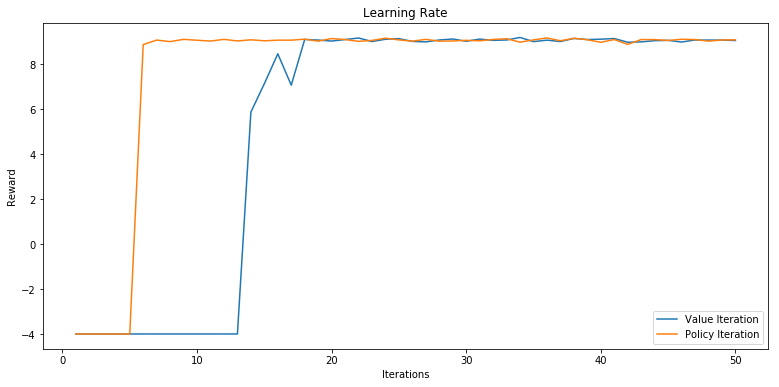

In [100]:
# Learning parameters
delta = 1e-3
gamma = 0.9
maxiters = 50  # Max number of iterations to perform

envname = "HugeLavaFloor-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: ", envname)
print("----------------------------------------------------------------\n")

env = gym.make(envname)
env.render()
print("\n")

series = []  # Series of learning rates to plot
liters = np.arange(maxiters + 1)  # Learning iteration values
liters[0] = 1
elimit = 100  # Limit of steps per episode
rep = 10  # Number of repetitions per iteration value
virewards = np.zeros(len(liters))  # Rewards array
c = 0

t = timer()

# Value iteration
for i in tqdm(liters, desc="Value Iteration", leave=True):
    reprew = 0
    policy = value_iteration(env, i, gamma, delta)  # Compute policy
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    virewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": virewards, "ls": "-", "label": "Value Iteration"})

vmaxiters = 5  # Max number of iterations to perform while evaluating a policy
pirewards = np.zeros(len(liters))  # Rewards array
c = 0

# Policy iteration
for i in tqdm(liters, desc="Policy Iteration", leave=True):
    reprew = 0
    policy = policy_iteration(env, i, vmaxiters, gamma, delta)  # Compute policy
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    pirewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": pirewards, "ls": "-", "label": "Policy Iteration"})

print("Execution time: {0}s".format(round(timer() - t, 4)))
np.set_printoptions(linewidth=10000)
print("Leaning rate comparison:\nVI: {0}\nPI: {1}".format(virewards, pirewards))

plot(series, "Learning Rate", "Iterations", "Reward")

Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thhing is the global trend.

### BiggerLavaFloor
![Bigger](results/bigger.png)

### HugeLavaFloor
![Huge](results/huge.png)